In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = '/content/drive/MyDrive/realwaste/realwaste-main/RealWaste'

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE = 524
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 5

In [7]:
import os

# Move or copy only the selected class folders into a new directory
selected_classes = ['Cardboard', 'Glass', 'Metal','Plastic']
new_dataset_path = '/path/to/new/dataset'
os.makedirs(new_dataset_path, exist_ok=True)

for cls in selected_classes:
    src = os.path.join(dataset_path, cls)
    dst = os.path.join(new_dataset_path, cls)
    if not os.path.exists(dst):
        os.symlink(src, dst)  # Or use shutil.copytree(src, dst)

# Load the new dataset
filtered_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

print("Filtered dataset size:", len(filtered_dataset))


Found 2592 files belonging to 4 classes.
Filtered dataset size: 162


In [8]:
class_names = filtered_dataset.class_names
class_names

['Cardboard', 'Glass', 'Metal', 'Plastic']

In [9]:
len(filtered_dataset)

162

(16, 524, 524, 3)
[0 1 3 2 0 0 3 2 0 3 2 3 2 3 2 1]


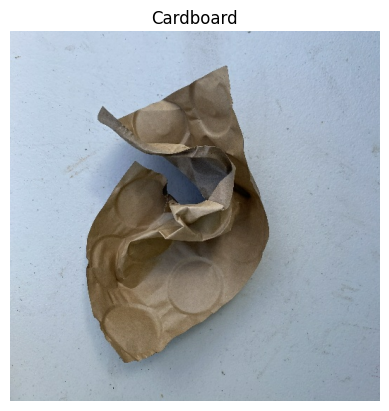

In [10]:
for image_batch, lable_batch in filtered_dataset .take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[lable_batch[0]])
    print(image_batch.shape)
    print(lable_batch.numpy())

In [11]:
# plt.figure(figsize = (10,10))
# for image_batch, lable_batch in dataset.take(1):
#     for i in range(12):
#         ax = plt.subplot(3,4,i+1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.axis("off")
#         plt.title(class_names[lable_batch[i]])

In [12]:
def get_dataset_partitions(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions(filtered_dataset)

In [14]:
len(train_ds) ,len(val_ds), len(test_ds)

(97, 32, 33)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# train_ds = train_ds.shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)  # No shuffle for val_ds
# test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)  # No shuffle for test_ds


In [16]:
import tensorflow as tf
# print(tf.__version__)
# print(tf.keras.__version__)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [19]:
input_shape = (524, 524, CHANNELS)
n_classes = 9

model = models.Sequential([
    tf.keras.Input(shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation = 'softmax')
])

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 524, 524, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 522, 522, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 261, 261, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 259, 259, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 129, 129, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1065024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      68,161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,183,369 (260.10 MB)

 Trainable params: 68,183,369 (260.10 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/5


In [ ]:
scores = model.evaluate(test_ds)